# Data Scraped, Downloaded & Cleaned

In [173]:
import re, json, time, requests, seaborn, warnings
warnings.filterwarnings('ignore')
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from matplotlib import pyplot as plt, rcParams
%matplotlib inline
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

### Source of Movies
In the cell below:
- I gather the urls for lists of the top 100 movies for each genre from rotten tomatoes. 
Note: Because I am only scraping movies from a top 100 list from rotten tomatoes, I am definitely gathering a biased selection of movies. Rotten tomatoes doesn't identify how they are ranking these movies as the "Top 100" so that could possibly introduce more bias into the data set. To help fix any bias that may be introduced by collecting my movies this way, I will be collecting a large number of movies, ~1000

In [2]:
base_url = "https://www.rottentomatoes.com"
action ="https://www.rottentomatoes.com/top/bestofrt/top_100_action__adventure_movies/"
url_finder = re.compile(r"/top/bestofrt/top_100_.*$")
page_source = requests.get(action).text
soup = BeautifulSoup(page_source, "html.parser")
urls = soup.find_all("a", href = url_finder )
top = []
for url in urls:
    top.append(base_url+url["href"])

### Collecting Movies' Names
In the cell below:
- I go to each url that was gathered in the cell above 
- I get the name of each movie on the list.

In [3]:
all_movies = []
for url in top:
    page_source = requests.get(url).text
    soup = BeautifulSoup(page_source, "html.parser")
    top_100 = soup.find('script', type='application/ld+json')
    data = json.loads(top_100.text)
    list_dict = data["itemListElement"]
    for top_movies in list_dict:
        page_source = requests.get(top_movies["url"]).text
        soup = BeautifulSoup(page_source, "html.parser")
        data = json.loads(soup.find('script', type='application/ld+json').text)
        all_movies.append(data["name"])

### Gathering Information on Each Movie
In the cell below:
- I create a set of the movies name. 
- For each movie I search IMDB for the specific movie, and pick the first result.
- I collect data for "Director", "Writer", "Star", "Release Date", "Budget", "Opening Weekend", "Gross"
- Any missing data is reported as NaN

IMDB is a reputable source for information, according to their website 

>"we [IMDB] actively gather information from and verify items with studios and 
filmmakers".

Because I am picking the first movie result, I may not be picking the exact movie that was listed on rotten tomatoes, which could produce some bias in my dataset. However, it is likely to be the most popular movie searched for, because it will be the first result

For each movie I search I collect the first name that appears under "Director", "Writer", and "Star" label. I'm only collecting the first name, because collecting more names can become very complicated very fast. Because I only select the first name, I am relying on IMDB to accurately place the most important person in that category first.

I also collect data on the release date, the budget for the movie, the amount of money spent on the movie during the opening weekend, and the gross profit made. 
Unfortunatley all these monetary amounts come in different currencies, so I will have to make this uniform and convert every currency to USD based on the date that the movie was released.

In [4]:
all_movies = list(set( all_movies ))
#This movie won't produce any results on IMDB with the parenthesis, which will
#create an error, so this is a quick fix.
oops=all_movies.index("The Good, the Bad, the Weird (Joheun-nom, Nabbeun-nom, Isanghan-nom)")
all_movies[oops] = "The Good, the Bad, the Weird"
n = len(all_movies)
data = [[movie] for movie in all_movies]
base_url = "http://www.imdb.com/"
browser = webdriver.Chrome()
browser.get(base_url)
for i in range(len(data)):
    # Get the search bar, type in some text, and press Enter.
    search_bar = browser.find_element_by_id("navbar-query")
    search_bar.clear() # Clear any pre-set text.
    search_bar.send_keys(data[i][0])
    search_bar.send_keys(Keys.RETURN) # Press Enter.
    soup = BeautifulSoup(browser.page_source,"html.parser")
    table = soup.find( name = "table" )
    link = table.find_all(name="td")[1]#choose first search result
    url = base_url+link.find(name="a")["href"]
    browser.get(url)#get page for first movie result
    soup = BeautifulSoup(browser.page_source,"html.parser")
    tab = soup.find_all(name="h4")
    D, W, S, B, O, G, R = False, False, False, False, False, False, False
    for j in tab:
        if j.text == "Director:" or j.text == "Directors:":
            data[i].append((" ").join(j.next_sibling.next_sibling.text.split()))
            D = True
        if j.text == "Writer:" or j.text == "Writers:":
            data[i].append((" ").join(j.next_sibling.next_sibling.text.split()))
            W = True
        if j.text == "Star:" or j.text == "Stars:":
            data[i].append((" ").join(j.next_sibling.next_sibling.text.split()))
            S = True
        if j.text == "Budget:":
            data[i].append((" ").join(j.next_sibling.split()))
            B = True
        if j.text == "Opening Weekend:":
            data[i].append((" ").join(j.next_sibling.split()))
            O = True
        if j.text == "Gross:":
            data[i].append((" ").join(j.next_sibling.split()))
            G = True
        if j.text == "Release Date:":
            data[i].append((" ").join(j.next_sibling.split()))
            R = True
    if not D:
        data[i].insert(1, np.nan)
    if not W:
        data[i].insert(2, np.nan)
    if not S:
        data[i].insert(3, np.nan)
    if not R:
        data[i].insert(4, np.nan)
    if not B:
        data[i].insert(5, np.nan)
    if not O:
        data[i].insert(6, np.nan)
    if not G:
        data[i].insert(7, np.nan)  
browser.close()

### Uncleaned Dataset

In [131]:
columns = ["Name","Director","Writer","Star","Release","Budget","Open","Gross"]
df = pd.DataFrame( data, index = np.arange(n), columns = columns )
df.head(3)

,Name,Director,Writer,Star,Release,Budget,Open,Gross
0,Poetry,Chang-dong Lee,Chang-dong Lee,"Jeong-hie Yun,",11 February 2011 (USA),"KRW 1,300,000,000","$18,900 (USA)","$355,044"
1,"Electric Boogaloo: The Wild, Untold Story of C...",Mark Hartley,Mark Hartley,"Sam Firstenberg,",5 June 2015 (UK),NaN,NaN,NaN
2,Every Little Step,"Adam Del Deo,",NaN,"German Alexander,",12 June 2009 (USA),NaN,"$68,504 (USA)","$1,724,351"


### Cleaning Data
In the cell below:

- I remove any phrases in parenthesis at the end of a name, so that all people with the same names will have the same spelling. 

- I remove the phrases in parenthesis after the release data, telling where the movie was first released. 

- I remove any commas at the end of names, and also in monetary amount to make it easier to convert them to ints later. 

- For each currency, I remove the symbol for the currency in place it in a new column that corresponds to opening weekend, and budget. 

- Each date is formated uniformly with pandas.to_datetime()

Note: Because all gross profits are listed in USD I will not have to worry about that column

In [132]:
df1=df
def remove_parenthesis(x):
    x=[str(i).split("(")[0] for i in x]
    return pd.Series(x)
def remove_comma(x):
    l=[]
    for i in x:
        l.append(("").join(str(i).split(",")))
    return pd.Series(l)
df1 = df1.apply(remove_parenthesis, axis = 1)
df1 = df1.apply(remove_comma, axis = 1)
df1[4] = df1[4].apply(lambda x: pd.to_datetime(str(x)))
def _type(x):
    if x == "nan":
        return np.nan
    xs=x.split()
    if len(xs)>1:
        return xs[0]
    else:
        return x[0]
def _int(x):
    if x == "nan":
        return np.nan
    xs=x.split()
    if len(xs)>1:
        return int(xs[1])
    else:
        return int(x[1:])
df1[8] = df1[5].apply(_type)
df1[9] = df1[6].apply(_type)
df1[5] = df1[5].apply(_int)
df1[6] = df1[6].apply(_int)
df1[7] = df1[7].apply(_int)
#column 7 is all in USD
#column 6 units described by column 9
#column 5 units described by column 8

### Finding Data to Convert Currency
In the cell below:
- I read in a dataset that I found that has values for the currency rates from dates from 1971 to 2017, for the exchange rate from USD to 26 different currencies

In [133]:
e_r_columns =["Dates","€","£","BRL","CNY", "DKK", "INR", "JPY", "KRW", "MYR", "MXN", "NOK", "SEK", "ZAR", "SGD", "CHF", "TWD", "THB", "VEB","NBDI","NMC","NOI","AUD", "NZD", "CAD", "HKD", "LKR"]
exchange_rates = pd.read_csv("exchange_rates.csv", skiprows = [0,1,2,4,5,6])#, index_col= e_r_columns)
exchange_rates.columns = e_r_columns
exchange_rates["Dates"] = exchange_rates["Dates"].apply(lambda x: pd.to_datetime(str(x)))

### Making Dataset Uniform
In the cell below:
- I use the previous data set to convert each currency that isn't in USD to USD.

In [134]:
def change_to_USD(x):
    date = x[4]
    if x[8] != "$" and x[8] != "nan":
        try:
            cur_rate = exchange_rates[x[8]][exchange_rates["Dates"] == date].values[0]
            x[5] = int(x[5]) / float(cur_rate)
        except:
            x[5] = np.nan
    elif x[9] != "$" and x[9] != "nan":
        try:
            cur_rate = exchange_rates[x[9]][exchange_rates["Dates"] == date].values[0]
            x[6] = int(x[6]) / float(cur_rate)
        except:
            x[5] = np.nan
    return x
df1 = df1.apply(change_to_USD, axis = 1)

### Data Cleaned and Uniform
In the cell below:
- I set my original dataset to the dataset that I have been manipulating so they are both the same

In [135]:
del df1[8]
del df1[9]
df = df1
df.columns = columns
df.head(3)

,Name,Director,Writer,Star,Release,Budget,Open,Gross
0,Poetry,Chang-dong Lee,Chang-dong Lee,Jeong-hie Yun,2011-02-11,1.154222e+06,18900.0,355044.0
1,Electric Boogaloo: The Wild Untold Story of Ca...,Mark Hartley,Mark Hartley,Sam Firstenberg,2015-06-05,NaN,NaN,NaN
2,Every Little Step,Adam Del Deo,nan,German Alexander,2009-06-12,NaN,68504.0,1724351.0


### Units
For the data set above:
- Dates have been uniformly written, using pands.to_datetime
- All currency is in USD

Note: It may be misleading that some entries in the opening weekends have a much larger value than the gross profit. This is because the opening weekends column describes all the money spent on that movie during the opening weekend. This is different from the gross, because the gross describes the profit after everyone has been paid.

In [136]:
df.to_csv("Cleaned_Data.csv")

# Initial Feature Engineering

In the cell below I create three new columns that can be useful later, when trying to detect trends in the data. 
- The first new column is a ratio of the budget of the movie to the money spent opening weekend. The second column is a ratio of the budget to the gross profit the movie made. The last new column is the ratio of the money spent on opening weekend to the gross profit made.
- I added these columns because it would make it easier to see if there was any type of correlation between factors contributing to ow much a movie made.
- After revising my previous code I decided that to make this code work a little better I should go back and replace the strings "nan" with np.nan.

In [138]:
bud_median = df["Budget"].median()
owk_median = df["Open"].median()
gro_median = df["Gross"].median()
df["Budget"] = df["Budget"].fillna( value = bud_median )
df["Open"] = df["Open"].fillna( value = owk_median )
df["Gross"] = df["Gross"].fillna( value = gro_median )
df["Budget.Open"] = df["Budget"]/df["Open"]
df["Budget.Gross"] = df["Budget"]/df["Gross"]
df["Open.Gross"] = df["Open"]/df["Gross"]
df.head(3)

,Name,Director,Writer,Star,Release,Budget,Open,Gross,Budget.Open,Budget.Gross,Open.Gross
0,Poetry,Chang-dong Lee,Chang-dong Lee,Jeong-hie Yun,2011-02-11,1.154222e+06,18900.000000,355044.0,61.069936,3.250926,0.053233
1,Electric Boogaloo: The Wild Untold Story of Ca...,Mark Hartley,Mark Hartley,Sam Firstenberg,2015-06-05,1.525000e+07,166334.867933,8057313.5,91.682521,1.892690,0.020644
2,Every Little Step,Adam Del Deo,nan,German Alexander,2009-06-12,1.525000e+07,68504.000000,1724351.0,222.614738,8.843907,0.039727


In [174]:
def change_nan(x):
    if x == "nan":
        return np.nan
    else:
        return x
df["Director"] = df["Director"].apply(change_nan)
df["Director"] = df["Director"].fillna( value = "" )
df["Writer"] = df["Writer"].apply(change_nan)
df["Writer"] = df["Writer"].fillna( value = "" )
df["Star"] = df["Star"].apply(change_nan)
df["Star"] = df["Star"].fillna( value = "" )
df=df.dropna()
def decade(x):
    year = x.year
    return ((year%1900)//10)*10+1900
df["Decade"] = df["Release"].apply(decade) #calculating the decade for the release date

In [140]:
df.to_csv("Engineered_Data.csv")

# Visualizing Data

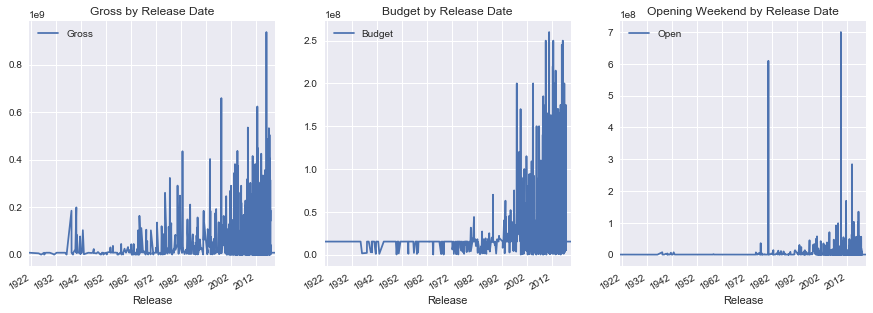

In [217]:
plt.figure(figsize=(15,5))
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)
df.plot(y="Gross", x="Release",title = "Gross by Release Date",ax=ax1)
df.plot(y="Budget",x="Release",title = "Budget by Release Date",ax=ax2)
df.plot(y="Open",x="Release",title = "Opening Weekend by Release Date",ax=ax3)

plt.show()

From these graphs it's noticable that the budget, gross profit, and opening weeking for movies has exponentially increased over the past century.

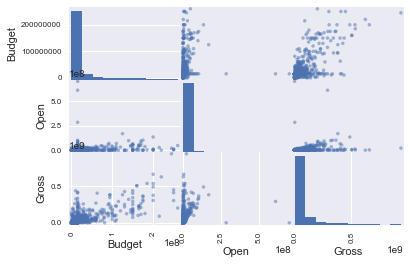

In [189]:
pd.plotting.scatter_matrix(df[["Budget","Open","Gross"]])
plt.show()

Observing the scatter matrix above, the budget and gross profit of a movie have a strong positive correlation, while gross profit and opening weekend, and opening weekend and budget both have weaker correlations.

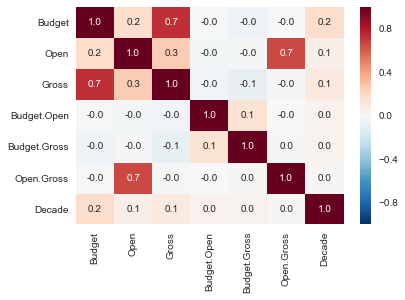

In [205]:
seaborn.heatmap(df.corr(), annot=True, fmt=".1f")
plt.show()

This heatplot shows that there is a stong correlation between the budget and gross, with a correlation coefficint of .7 (confirming what the scatterplot demonstrated), also there is a slight positive correlation between the release decade and the budget for the movie. There is also a correlation between the opening weekend and gross, with a coefficient of .3. Interestingly, none of the ratios are in any way correlated to each other.

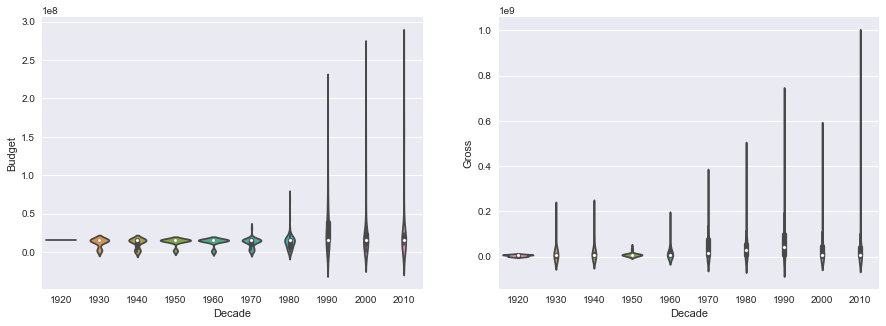

In [216]:
plt.figure(figsize=(15,5))
ax1,ax2 = plt.subplot(121),plt.subplot(122)
seaborn.violinplot(x="Decade",y="Budget",data=df,ax=ax1)
seaborn.violinplot(x="Decade",y="Gross",data=df,ax=ax2)
plt.show()

The first plot shows the distribution of the budget for each decade using the width of each "violin". This violin plot above demonstrates a much larger variance in the budgets for movies in later decades than in previous decades.The second violin plot for the gross profit of movies versus the decade, shows that the gross profit for movies is significantly more variant than the budget for the movies.